# Finding free stock index data with Python and EDGAR
A stock index is just a list of stocks. The index is a special list because investors use it to make investing decisions. The index also has a few rules related to what is included, how much of it to include, and when to include (or remove it). Finding this data, especially for more obscure indexes can be difficult, especially if you want to find this data for free. This article will show you one technique to find stock index information using free data, all with standard Python tools - all code included.

We will use pandas, lxml, matplotlib, and a little elbow grease.

## What is a stock index?
A stock index is a bit more than just a list of stocks. We are interested in three pieces of information: the list, the weights, and a date that the index changes.

### List
Choosing the stocks that go into an index can be somewhat complicated. Each index will have some guidelines for how the stocks are selected and who makes the decisions on index inclusion. Most indexes can only change their constituents (a name for the members of the index) four times per year. For example, consider an index that contains the top 100 stocks by market capitalization for an exchange. As stocks go up and down in price, or as companies merge with other companies, it may be necessary to remove some and add others to the list. 

### Weights
You can think of the index as a list of weights. Each stock in the index will have a weight, and the sum of the weights will be 1. An index could be equal weighted: it could contain 100 equally weighted stocks having a weight of 0.01 per stock. Usually indexes are weighted by market capitalization. Market capitalization is the total value of the outstanding shares in the market. The higher market cap stocks will have a bigger weight than the smaller ones. The act of recalculating the weights and adding or removing stocks from the list is called rebalancing.

### History
The index rebalance happens on a certain date, usually once per quarter, and so any analysis of historical index data requires a history of index weights and constituents.

In terms of ease to obtain this data, the easiest to find is the list, but the weights and historical data can be a bigger challenge to find.

## Index examples
Some common stock indexes that many people have heard of in the United States are the [Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) (a.k.a. "The Dow"), the [S&P 500](https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview), and the [Nasdaq 100](https://www.nasdaq.com/nasdaq-100). There are many more indexes, including indexes in other countries, like the [FTSE 100](https://www.londonstockexchange.com/indices/ftse-100) on the London Stock Exchange. 

The news media will often report on the daily performance of the Dow when discussing the market. If you aren't a finance person, you may not know that practically no one in finance cares about the Dow. For historical reasons, the media likes to tell us "the market was up 300 points today", when usually we are interested in percentage point changes of the S&P500. The Dow is a bad index to use for investors for a few reasons, which we will demonstrate in this article.

The S&P 500 is a well known index maintained by S&P Global. The stocks in the index are from 500 US companies, and they are roughly the 500 largest by market capitalization. Companies are moved in and out of the index based on a set of rules created by S&P, and the index is rebalanced quarterly. The index currently has 503 stocks in it (as of time of writing) because three of the 500 companies have 2 types of common stock, and both symbols are included in the index. If you want to know more details about how S&P constructs and maintains their indexes, here's a [detailed document describing the rules](https://www.spglobal.com/spdji/en/documents/methodologies/methodology-sp-us-indices.pdf).

Side note, I will choose to use the term _indexes_ instead of _indices_ for the plural of index, even though in this context _indices_ would be appropriate. You will see both used in a financial context, but I find indexes to be more comfortable.

S&P makes their money by providing market data, including the most current data about the indexes that they maintain. While you can pretty easily find the current stocks that are in a popular index like the Dow or S&P 500, finding the historical values that are in the index, as well as their weights, can be a challenge. S&P would rather just sell you this data, and if you work at a large bank or hedge fund, your company probably pays S&P (or a competitor) a fair amount of money for a database of index values, weights, and the dates for each of these values.

It turns out that you can pretty closely approximate this data for free, if you're willing to put in the work to find it and clean it up.

To do that, we'll use Python and various Python libraries to access the SEC's EDGAR system. You can read all about what EDGAR and the SEC is and how to setup your environment to read EDGAR data [in this article](https://www.wrighters.io/an-introduction-to-accessing-financial-data-in-edgar-using-python/). However, I'll cover some of the details here as well.

## How do we find index data in EDGAR?
The approach that we'll take to find the elements of an index is to look for an Exchange Traded Fund (ETF) that tracks the index. One of the main reason indexes exist is so that investors can measure their investing success against what "the market" does. If you decided to buy 10 stocks and hold them for one year, at the end of that year, how would you know if you did a good job of picking stocks? One way is to compare *your* performance to the performance of a stock index. Over the years, many investors learned that outperforming the index was really difficult, and just buying *all* the stocks in the index was much easier. You won't beat the index, but you will also not underperform it (except for fees). But buying all 503 stocks is difficult and expensive, so the financial industry offers a solution in the form of an ETF. The ETF is a special fund that contains all the stocks in the index. Since ETFs are listed securities, the SEC requires them to make regular filings, and those filings are in the EDGAR database.

If you want to own the S&P 500 index, there are many ETFs that track it. The most common one is SPY, although there are many others, and the others tend to have lower fees.

For this article though, since we want to make some of the manual steps later a little easier we will use the Dow Jones Industrial Average. It is an inferior index for investing, but since it has only 30 stocks, it serves well for an example. It turns out there is an ETF for the Dow, and it's called DIA.


## What filings are available for ETFs?
You can go into EDGAR and search for all the filings using their search form. Here are [the results](https://www.sec.gov/edgar/browse/?CIK=1041130&owner=exclude) for DIA.

A filing is required by the SEC called N-PORT that contains the portfolio investments for an ETF. This report comes out quarterly, and at the time of writing the [most recent report](https://www.sec.gov/Archives/edgar/data/1041130/000175272422213777/xslFormNPORT-P_X01/primary_doc.xml) is for the 2022-07-31 reporting date (but was filed on 2022-09-23).

Let's take a look at what this report looks like. I'll go through this without a ton of explanation (you can refer to the earlier article for details).

In [1]:
import requests
import json
from lxml import etree

import pandas as pd

In [2]:
website = "example.org" # your website
email = "email@example.org" # your email

In [3]:
headers = {"User-Agent": f"{website} {email}"}

In [4]:
# get the XML document directly (note, this is not the html version linked to above, but the underlying xml doc)
nport = requests.get("https://www.sec.gov/Archives/edgar/data/1041130/000175272422213777/primary_doc.xml", headers=headers)

In [5]:
nport.raise_for_status()

In [6]:
nport.content[:100]

b'<?xml version="1.0" encoding="UTF-8"?><edgarSubmission xmlns="http://www.sec.gov/edgar/nport" xmlns:'

In [7]:
doc = etree.fromstring(nport.content)

## Parsing out the data
Now I'll make things look really easy here, but in reality I had to manually inspect a few examples of the N-PORT data to figure out how it was structured. I also took a look at the [filing instructions](https://www.sec.gov/files/formn-port.pdf) supplied by the SEC, as well as the [technical specs](https://www.sec.gov/edgar/filer-information/specifications/form-n-port-xml-tech-specs) for the xml. You can pull up the raw [xml](https://www.sec.gov/Archives/edgar/data/1041130/000175272422213777/primary_doc.xml) to see the structure, and you can dig into the specs if you want to learn more. I learned that the investments are all located in the `invstOrSec` section of the document. Using `lxml`, we can make an XPath expression to select only those values.

In [8]:
investments = doc.xpath("//nport:invstOrSec", namespaces={'nport':'http://www.sec.gov/edgar/nport'})

In [9]:
investments[0].xpath("nport:name", namespaces={'nport':'http://www.sec.gov/edgar/nport'})[0].text

'Honeywell International Inc'

You can see the first element is for Honeywell. I then found a nice [code snippet](https://gist.github.com/jacobian/795571) to use that would convert an `lxml` document into a simple Python dict for easier manipulation.

In [10]:
# from https://gist.github.com/jacobian/795571
def elem2dict(node):
    """
    Convert an lxml.etree node tree into a dict.
    """
    result = {}

    for element in node.iterchildren():
        # Remove namespace prefix
        key = element.tag.split('}')[1] if '}' in element.tag else element.tag

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)
        if key in result:

            
            if type(result[key]) is list:
                result[key].append(value)
            else:
                tempvalue = result[key].copy()
                result[key] = [tempvalue, value]
        else:
            result[key] = value
    return result

In [11]:
data = [elem2dict(i) for i in investments]

In [12]:
print(len(data))
data[0]

30


{'name': 'Honeywell International Inc',
 'lei': 'ISRPG12PN4EIEOEMW547',
 'title': 'Honeywell International Inc',
 'cusip': '438516106',
 'identifiers': {'isin': {}},
 'balance': '5706213.00000000',
 'units': 'NS',
 'curCd': 'USD',
 'valUSD': '1098217753.98000000',
 'pctVal': '3.858904435656',
 'payoffProfile': 'Long',
 'assetCat': 'EC',
 'issuerCat': 'CORP',
 'invCountry': 'US',
 'isRestrictedSec': 'N',
 'fairValLevel': '1',
 'securityLending': {'isCashCollateral': 'N',
  'isNonCashCollateral': 'N',
  'isLoanByFund': 'N'}}

## Further analysis with pandas and matplotlib
Now you can see that the first investment has a few interesting fields, including the name, the cusip (a standard identifier we'll talk about in the future), the balance of shares (`balance` and `units` - `NS` means _Number_ of _Shares_) and the percentage of the total investment (`pctVal`). We can make a pandas `DataFrame` of this data for some further analysis.

In [13]:
df = pd.DataFrame(data)

Note that in the data above, the numbers are passed in as text, so let's convert `balance`, `valUSD`, and `pctVal` into numbers. If you would like an overview of converting data in pandas, check out [this article](https://www.wrighters.io/converting-types-in-pandas/).

In [14]:
for c in ['balance', 'valUSD', 'pctVal']:
    df[c] = pd.to_numeric(df[c])

In [15]:
df[['name', 'cusip', 'balance', 'units', 'pctVal']]

,name,cusip,balance,units,pctVal
0,Honeywell International Inc,438516106,5706213.0,NS,3.858904
1,Cisco Systems Inc,17275R102,5706213.0,NS,0.909688
2,Salesforce Inc,79466L302,5706213.0,NS,3.689679
3,Dow Inc,260557103,5706241.0,NS,1.066888
4,Johnson & Johnson,478160104,5706213.0,NS,3.499200
5,McDonald's Corp,580135101,5706213.0,NS,5.280680
6,UnitedHealth Group Inc,91324P102,5706213.0,NS,10.874146
7,International Business Machines Corp,459200101,5706213.0,NS,2.622395
8,3M Co,88579Y101,5706213.0,NS,2.872023
9,NIKE Inc,654106103,5706213.0,NS,2.304195


Just from inspection, you might see a few things you can learn about this index, but let's visualize the data a bit to illustrate a point or two about it. One way to do this is to just show a pie chart of both the `pctVal` and `balance` columns. Let's make a function to do this which we'll use later for comparing with another index.

In [16]:
from matplotlib import pyplot as plt

def plot_index(df, name, sort='pctVal'):
    fig, axes = plt.subplots(1,2, figsize=(12,8))
    df = df.sort_values(by=sort, ascending=False)
    fig.suptitle(f"Shares vs % of Total for {name}")
    axes[0].pie(df['balance'])
    labels = df['name'].copy()
    labels.iloc[min(25, len(labels)):] = ''
    axes[1].pie(df['pctVal'], labels=labels, rotatelabels=True);

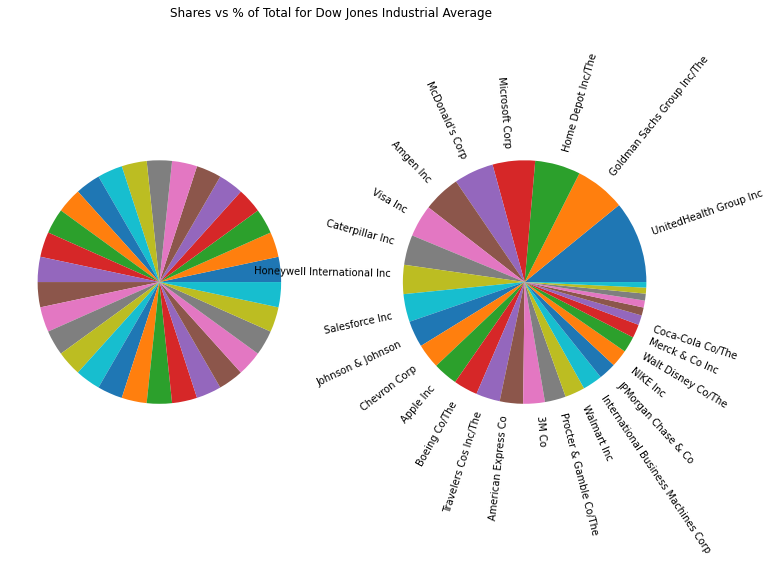

In [17]:
plot_index(df, "Dow Jones Industrial Average")

## Comparing indexes
Let's now go ahead and grab the Nasdaq 100 index. The ETF QQQ tracks the Nasdaq 100, and so we can grab a recent N-PORT filing for it just like we did for DIA. I'll do this all in one go, just repeating the steps from above, but with a recent filing for QQQ.

In [18]:
def get_nport_values(url):
    nport = requests.get(url, headers=headers)
    nport.raise_for_status()
    doc = etree.fromstring(nport.content)
    investments = doc.xpath("//nport:invstOrSec", namespaces={'nport':'http://www.sec.gov/edgar/nport'})
    data = [elem2dict(i) for i in investments]
    df = pd.DataFrame(data)
    for c in ['balance', 'valUSD', 'pctVal']:
        df[c] = pd.to_numeric(df[c])
    return df

In [19]:
# recent nport document for QQQ
url = "https://www.sec.gov/Archives/edgar/data/1067839/000175272422184608/primary_doc.xml"
df_n100 = get_nport_values(url)

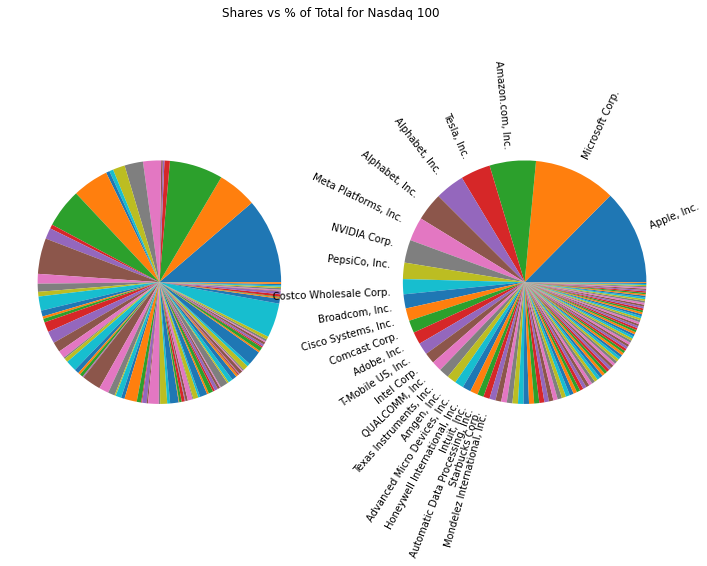

In [20]:
plot_index(df_n100, 'Nasdaq 100')

### Share counts
These two sets of pie charts do a good job of showing you the difference between these two types of indexes. It's pretty clear that the Dow is equally weighted by shares, or the left pie chart. Each slice is the same size. In the Nasdaq 100, the share sizes don't especially line up with the percentage of the total value.

### Percentage of value
Look at the top three holdings in the Dow by value and the bottom three, and do the same for the Nasdaq 100.

In [21]:
df.sort_values(by='pctVal').head(3)[['name', 'pctVal']]

,name,pctVal
20,Intel Corp,0.728031
10,Walgreens Boots Alliance Inc,0.794398
1,Cisco Systems Inc,0.909688


In [22]:
df.sort_values(by='pctVal').tail(3)[['name', 'pctVal']]

,name,pctVal
6,UnitedHealth Group Inc,10.874146
21,Goldman Sachs Group Inc/The,6.684611
19,Home Depot Inc/The,6.033974


In [26]:
df_n100.sort_values(by='pctVal').head(3)[['name', 'pctVal']]

,name,pctVal
83,"DocuSign, Inc.",0.108177
41,"Okta, Inc.",0.128520
34,"Splunk, Inc.",0.134234


In [25]:
df_n100.sort_values(by='pctVal').tail(3)[['name', 'pctVal']]

,name,pctVal
10,"Amazon.com, Inc.",6.142787
67,Microsoft Corp.,10.918983
17,"Apple, Inc.",12.578838


If you don't follow the stock market, this might not be obvious, but Apple, Microsoft, and Amazon have much larger market capitalizations than DocuSign, Okta, and Splunk. But why is UnitedHealth group 10% of the Dow, when Intel is only 0.72 % ? UnitedHealth has a stock price of around \\$500, but Intel has a price around \\$25. However, their market capitaliations are ~ \\$479B and \\$105B respectively. You can see that a price weighted index is very different from a market cap weighted index.

## Where do we go from here?
We've now just scratched the surface with using the EDGAR data to understand what is in an index. There is a lot more useful data in EDGAR about each of the stocks in the index. But to access it, we will need to map the value in the N-PORT report back to a stock ticker. You'll notice that we have a name and a CUSIP, but not a ticker. We'll tackle that problem next.